In [1]:
import os
import shutil
import glob
import json
import pickle
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import cv2
import skimage.io as io
from skimage.transform import resize
import scipy
from skimage.filters import sobel
from skimage.feature import graycomatrix , graycoprops
from skimage.measure import shannon_entropy
import lightgbm as lgbm
from imblearn.over_sampling import SMOTE
import tensorflow
from PIL import Image

from sklearn.preprocessing import MinMaxScaler, Normalizer, StandardScaler, RobustScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score, cross_validate, RandomizedSearchCV, GridSearchCV
from sklearn.utils import shuffle
from sklearn.metrics import (confusion_matrix, classification_report, accuracy_score, f1_score, recall_score, precision_score,
                             auc, roc_curve, roc_auc_score, cohen_kappa_score, plot_confusion_matrix, plot_roc_curve,
                             plot_precision_recall_curve, precision_recall_fscore_support, precision_recall_curve)
from sklearn.utils import compute_class_weight
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC 
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img, ImageDataGenerator, save_img
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import Sequential, Model, load_model, model_from_json
from tensorflow.keras.layers import (Input, InputLayer, Conv2D, MaxPooling2D, Dense, Concatenate, BatchNormalization, Dropout, Activation, GlobalAveragePooling2D, InputSpec, Flatten, Concatenate)
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input
from tensorflow.keras.applications.resnet_v2 import ResNet101V2, preprocess_input
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adadelta, Adagrad
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.metrics import Accuracy, AUC, Precision, Recall
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

import warnings
warnings.filterwarnings("ignore")

In [5]:
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2

In [6]:
!pip install natsort
from natsort import natsorted

In [7]:
yes_path='../input/brain-tumor-detection/yes'
no_path='../input/brain-tumor-detection/no'
merged_train='../input/yesno/yes-no'
train_set_path='../input/dataclasses'

test_set_path='../input/testyesno/test/test'

In [8]:
classes = os.listdir(train_set_path)
class2label = {}

for i in range(len(classes)):
    class2label[classes[i]] = i
    
label2class = {v:k for k, v in class2label.items()}

print(class2label)
print("--"*45)
print(label2class)

{'no': 0, 'yes': 1}
------------------------------------------------------------------------------------------
{0: 'no', 1: 'yes'}


In [9]:
classes = os.listdir(test_set_path)
class2label = {}

for i in range(len(classes)):
    class2label[classes[i]] = i
    
label2class = {v:k for k, v in class2label.items()}

print(class2label)
print("--"*45)
print(label2class)

{'no': 0, 'yes': 1}
------------------------------------------------------------------------------------------
{0: 'no', 1: 'yes'}


In [10]:
no_list=os.listdir(no_path)
yes_list=os.listdir(yes_path)
training_set=os.listdir(merged_train)

test_set=os.listdir(test_set_path)

In [11]:
print(len(training_set))
print(len(test_set))

3000
2


In [12]:
train_set=natsorted(training_set)
test_set=natsorted(test_set)

In [13]:
def show_img(number):
    
    fig=plt.figure(figsize=(15,15))
    
    for i in range(number):
        image_num=random.randint(0,3000)
        
        if image_num<1500:
            #plt.figure(figsize=(3,3))
            a=fig.add_subplot(1,number,i+1)
            plt.imshow(plt.imread(os.path.join(no_path,train_set[image_num])))
            plt.xlabel('No BT')
        else:
            #plt.figure(figsize=(3,3))
            a=fig.add_subplot(1,number,i+1)
            plt.imshow(plt.imread(os.path.join(yes_path, train_set[image_num])))
            plt.xlabel('Yes BT')
        plt.tight_layout()

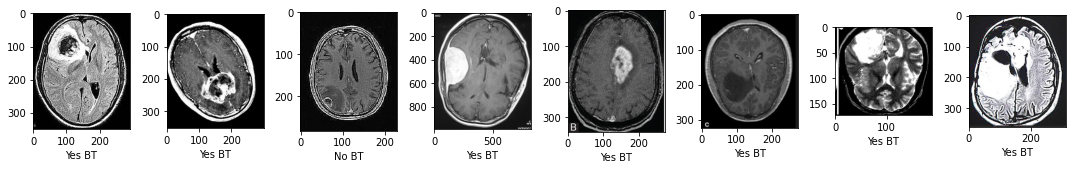

In [14]:
show_img(8)

In [15]:
train_distribution = {}
print("TRAIN-SET DISTRIBUTION\n")
for cat in classes:
    path = os.path.join(train_set_path, cat, "*")
    data = glob.glob(path)
    print(f"Number of {cat} Images: {len(data)}")
    train_distribution[cat] = len(data)
    print('--'*20)   

test_distribution = {}
print("\nVAL-SET DISTRIBUTION\n")
for cat in classes:
    path = os.path.join(test_set_path, cat, "*")
    data = glob.glob(path)
    print(f"Number of {cat} Images: {len(data)}")
    test_distribution[cat] = len(data)
    print('--'*20)

TRAIN-SET DISTRIBUTION

Number of no Images: 1500
----------------------------------------
Number of yes Images: 1500
----------------------------------------

VAL-SET DISTRIBUTION

Number of no Images: 98
----------------------------------------
Number of yes Images: 155
----------------------------------------


In [16]:
categories = []
image_name = []
image_id = []
image_format = []
labels = []
img_path = []
img_height = []
img_width = []

for cat in classes:
    path = os.path.join(train_set_path, cat, "*")
    data = glob.glob(path)
    for i in range(len(data)):
        h, w, c = cv2.imread(data[i]).shape
        cls , img = data[i].split('/')[-2:]
        img_id , img_format = img.split('.')
        img_height.append(h)
        img_width.append(w)
        categories.append(cls)
        image_name.append(img)
        image_id.append(img_id)
        image_format.append(img_format) 
        labels.append(class2label[cls])
        img_path.append(data[i])

In [17]:
assert len(categories) == len(image_name) == len(image_id) == len(image_id) == len(image_format) == len(labels) == len(img_path) == len(img_height) == len(img_width)

In [18]:
data = pd.DataFrame(list(zip(image_id, image_name, image_format, categories, labels, img_path, img_height, img_width)))
data.columns = ['image_id' , 'image_name' , 'format' , 'Class' , 'label' , 'image_path' , 'height' , 'width']
data.sample(10 , random_state = 42)

,image_id,image_name,format,Class,label,image_path,height,width
1801,y1148,y1148.jpg,jpg,yes,1,../input/dataclasses/yes/y1148.jpg,325,300
1190,no1069,no1069.jpg,jpg,no,0,../input/dataclasses/no/no1069.jpg,244,206
1817,y753,y753.jpg,jpg,yes,1,../input/dataclasses/yes/y753.jpg,365,306
251,no1210,no1210.jpg,jpg,no,0,../input/dataclasses/no/no1210.jpg,442,441
2505,y740,y740.jpg,jpg,yes,1,../input/dataclasses/yes/y740.jpg,349,292
1117,no1015,no1015.jpg,jpg,no,0,../input/dataclasses/no/no1015.jpg,168,300
1411,no1389,no1389.jpg,jpg,no,0,../input/dataclasses/no/no1389.jpg,222,227
2113,y646,y646.jpg,jpg,yes,1,../input/dataclasses/yes/y646.jpg,355,294
408,no731,no731.jpg,jpg,no,0,../input/dataclasses/no/no731.jpg,225,225
2579,y1382,y1382.jpg,jpg,yes,1,../input/dataclasses/yes/y1382.jpg,258,300


In [19]:
data.shape

(3000, 8)

In [20]:
data['Class'].value_counts()

no     1500
yes    1500
Name: Class, dtype: int64

In [21]:
if data.isnull().sum().sum() == 0:
    print('No Null Values found in whole dataset')
else:
    print(f'{data.isnull().sum().sum()} null values found in dataset')

# checking for any duplicate values
if data.duplicated().sum() == 0:
    print('No Duplicate Values found in dataset')
else:
    print(f'{data.duplicated().sum()} Duplicate values found in dataset')

No Null Values found in whole dataset
No Duplicate Values found in dataset


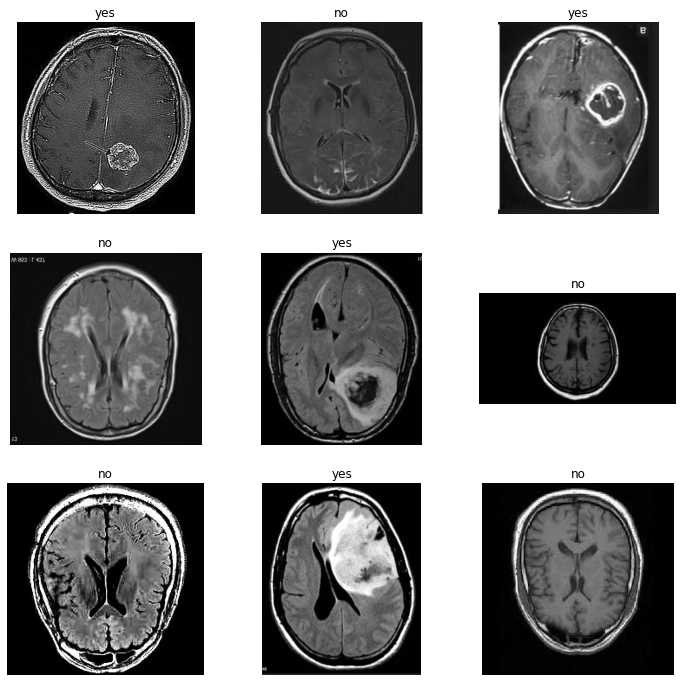

In [22]:
sample_data = data.sample(12 , random_state = 42)
sample_imgs = sample_data['image_path'].to_list()

plt.figure(figsize = (12,12))
for i in range(9):
    plt.subplot(3 , 3 , i+1)
    img = cv2.imread(sample_imgs[i])
    plt.title(sample_imgs[i].split('/')[-2], fontsize = 12)
    plt.axis('off')
    plt.imshow(img)
    
plt.savefig("brainPlots.png")

In [23]:
print('Shape of the image : {}'.format(img.shape))
print('Image Height: {}'.format(img.shape[0]))
print('Image Width: {}'.format(img.shape[1]))
print('Image Dimensions/Channels: {}'.format(img.ndim))
print("=="*20)
print('Image size: {}'.format(img.size))
print('Image Data Type: {}'.format(img.dtype))
print("=="*20)
print('Maximum RGB value in this image {}'.format(img.max()))
print('Minimum RGB value in this image {}'.format(img.min()))

Shape of the image : (225, 225, 3)
Image Height: 225
Image Width: 225
Image Dimensions/Channels: 3
Image size: 151875
Image Data Type: uint8
Maximum RGB value in this image 255
Minimum RGB value in this image 0


In [24]:
mean_val = []
std_val = []
max_val = []
min_val = []
med_val = []


for i in range(data.shape[0]):
    img_arr = img_to_array(load_img(data['image_path'][i]))
        
    mean_val.append(img_arr.mean())
    std_val.append(img_arr.std())
    max_val.append(img_arr.max())
    min_val.append(img_arr.min())
    med_val.append(np.median(img_arr))
    
data['mean_pixel'] = mean_val
data['std_dev'] = std_val
data['max_pixel'] = max_val
data['min_pixel'] = min_val
data['median'] = med_val

data['mean_variation'] = data['mean_pixel'].mean() - data['mean_pixel']

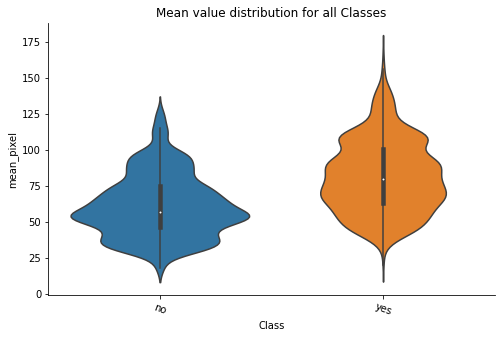

In [25]:
plt.figure(figsize = (8,5))
sns.violinplot(y = 'mean_pixel' , data = data , x = 'Class')
sns.despine()
plt.xticks(rotation=340)
plt.title('Mean value distribution for all Classes')
plt.savefig("meanValue.png")
plt.show()

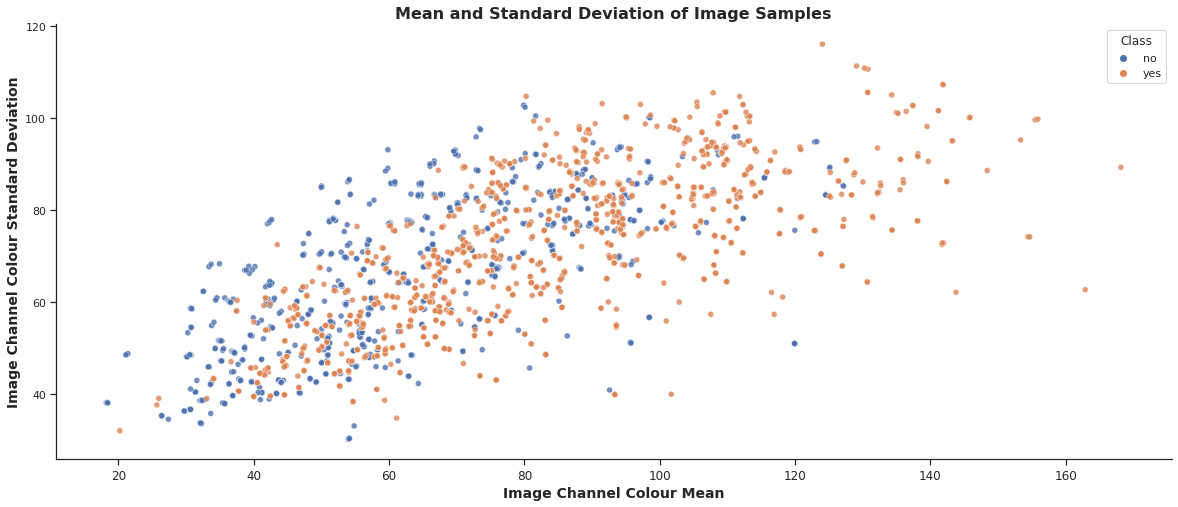

In [26]:
plt.figure(figsize=(20,8))
sns.set(style="ticks", font_scale = 1)
ax = sns.scatterplot(data=data, x="mean_pixel", y=data['std_dev'], hue = 'Class',alpha=0.8);
sns.despine(top=True, right=True, left=False, bottom=False)
plt.xticks(rotation=0,fontsize = 12)
ax.set_xlabel('Image Channel Colour Mean',fontsize = 14,weight = 'bold')
ax.set_ylabel('Image Channel Colour Standard Deviation',fontsize = 14,weight = 'bold')
plt.title('Mean and Standard Deviation of Image Samples', fontsize = 16,weight = 'bold');

In [27]:
BATCH_SIZE = 64
NUM_EPOCHS = 75
IMG_SIZE = 256
INPUT_SHAPE = (256, 256, 3)
TARGET_SIZE = (256, 256)

In [28]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                    featurewise_std_normalization=True,
                                    zca_epsilon=1e-06,
                                    rotation_range=16,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    brightness_range=[0.5,1.5],
                                    shear_range=0.2,
                                    horizontal_flip=True,
                                    vertical_flip=True)

test_datagen  = ImageDataGenerator(rescale=1./255,
                                    featurewise_std_normalization=True,
                                    zca_epsilon=1e-06,
                                    rotation_range=16,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    brightness_range=[0.5,1.5],
                                    shear_range=0.2,
                                    horizontal_flip=True,
                                    vertical_flip=True)   
    

In [29]:
train_dataset  = train_datagen.flow_from_directory(directory = train_set_path,
                                                   target_size = TARGET_SIZE,
                                                   color_mode = "rgb",
                                                   class_mode = "binary",
                                                   batch_size = BATCH_SIZE,
                                                   shuffle = True)    

test_dataset = test_datagen.flow_from_directory(directory = test_set_path,
                                               target_size = TARGET_SIZE,
                                               color_mode = "rgb",
                                               class_mode = "binary",
                                               batch_size = BATCH_SIZE,
                                               shuffle = False)

Found 3000 images belonging to 2 classes.
Found 253 images belonging to 2 classes.


In [30]:
os.mkdir("./temp/")
checkpoint_filepath = "./temp/"

In [31]:
optimizer = Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-09)
metrics = ["accuracy", Recall(), Precision(), AUC()]

early_stop = EarlyStopping(monitor='val_loss', patience=6, mode='min', verbose=1)
checkpoint = ModelCheckpoint(filepath=checkpoint_filepath, monitor="val_loss", verbose=1, save_best_only=True, mode="min")
lr_reduction = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, verbose=1, mode="min")
callbacks_list = [early_stop, lr_reduction, checkpoint]

2022-08-05 17:56:46.398454: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-05 17:56:46.399727: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-05 17:56:46.400496: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-05 17:56:46.401529: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [32]:
base_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=INPUT_SHAPE)
x = base_model.output

x = Dropout(0.25)(x)
x = GlobalAveragePooling2D()(x)

x = Dense(500,  kernel_initializer='he_uniform')(x)
x = Activation('relu')(x)
x = Dropout(0.25)(x)

output = Dense(1, activation='sigmoid')(x)
model = Model(inputs=base_model.input, outputs=output, name="DenseNet_Network")

model.summary()

9420800/9406464 [==============================] - 0s 0us/step
Model: "DenseNet_Network"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 128, 128, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 128, 128, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 128, 128, 32) 0           bn_Conv1[0][0]                   
____________________

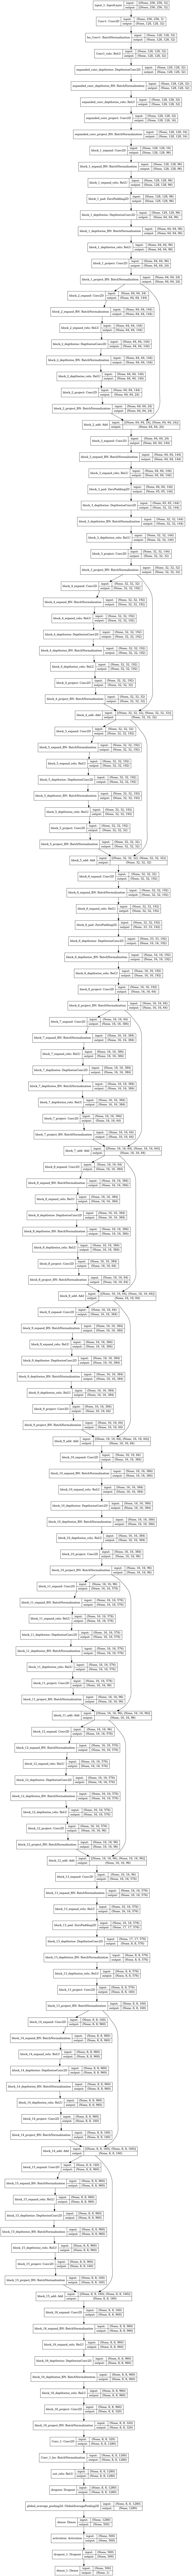

In [33]:
plot_model(model, 'finalModel.png', show_shapes=True)

In [34]:
model.compile(optimizer = optimizer, loss = "binary_crossentropy", metrics = metrics)

In [35]:
train_dataset

In [36]:
test_dataset

In [37]:
hist = model.fit(x=train_dataset, epochs=NUM_EPOCHS, callbacks=[callbacks_list], steps_per_epoch=len(train_dataset),
                 validation_data=test_dataset, validation_steps=len(test_dataset))

2022-08-05 17:56:54.987026: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/75


2022-08-05 17:57:01.770236: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


47/47 [==============================] - 84s 2s/step - loss: 0.3253 - accuracy: 0.8513 - recall: 0.8447 - precision: 0.8561 - auc: 0.9354 - val_loss: 1.2327 - val_accuracy: 0.5375 - val_recall: 0.2516 - val_precision: 0.9750 - val_auc: 0.9035

Epoch 00001: val_loss improved from inf to 1.23267, saving model to ./temp/


2022-08-05 17:58:27.280396: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


Epoch 2/75
47/47 [==============================] - 69s 1s/step - loss: 0.0813 - accuracy: 0.9690 - recall: 0.9640 - precision: 0.9737 - auc: 0.9961 - val_loss: 0.6439 - val_accuracy: 0.7826 - val_recall: 0.6516 - val_precision: 0.9902 - val_auc: 0.9556

Epoch 00002: val_loss improved from 1.23267 to 0.64393, saving model to ./temp/
Epoch 3/75
47/47 [==============================] - 69s 1s/step - loss: 0.0437 - accuracy: 0.9857 - recall: 0.9847 - precision: 0.9866 - auc: 0.9982 - val_loss: 0.4730 - val_accuracy: 0.8221 - val_recall: 0.7161 - val_precision: 0.9911 - val_auc: 0.9656

Epoch 00003: val_loss improved from 0.64393 to 0.47303, saving model to ./temp/
Epoch 4/75
47/47 [==============================] - 69s 1s/step - loss: 0.0287 - accuracy: 0.9900 - recall: 0.9900 - precision: 0.9900 - auc: 0.9992 - val_loss: 0.1819 - val_accuracy: 0.9368 - val_recall: 0.9355 - val_precision: 0.9603 - val_auc: 0.9805

Epoch 00004: val_loss improved from 0.47303 to 0.18195, saving model to ./t

In [38]:
model.save('MobileNet_Model.h5')

model_json = model.to_json()
with open("Model.json", "w") as json_file:
    json_file.write(model_json)

model.save_weights("Model_Weights.h5")
print("Saved model to disk")

Saved model to disk


In [39]:
metricsEval = list(hist.history.keys())
print(metricsEval , '\n')

historyDF = pd.DataFrame(hist.history)
historyDF.head()

['loss', 'accuracy', 'recall', 'precision', 'auc', 'val_loss', 'val_accuracy', 'val_recall', 'val_precision', 'val_auc', 'lr'] 



,loss,accuracy,recall,precision,auc,val_loss,val_accuracy,val_recall,val_precision,val_auc,lr
0,0.325255,0.851333,0.844667,0.856081,0.935376,1.232674,0.537549,0.251613,0.975000,0.903489,0.0001
1,0.081292,0.969000,0.964000,0.973737,0.996127,0.643927,0.782609,0.651613,0.990196,0.955563,0.0001
2,0.043733,0.985667,0.984667,0.986640,0.998199,0.473031,0.822134,0.716129,0.991071,0.965569,0.0001
3,0.028711,0.990000,0.990000,0.990000,0.999235,0.181946,0.936759,0.935484,0.960265,0.980546,0.0001
4,0.023030,0.991000,0.992000,0.990020,0.999649,0.221170,0.932806,0.903226,0.985915,0.980020,0.0001


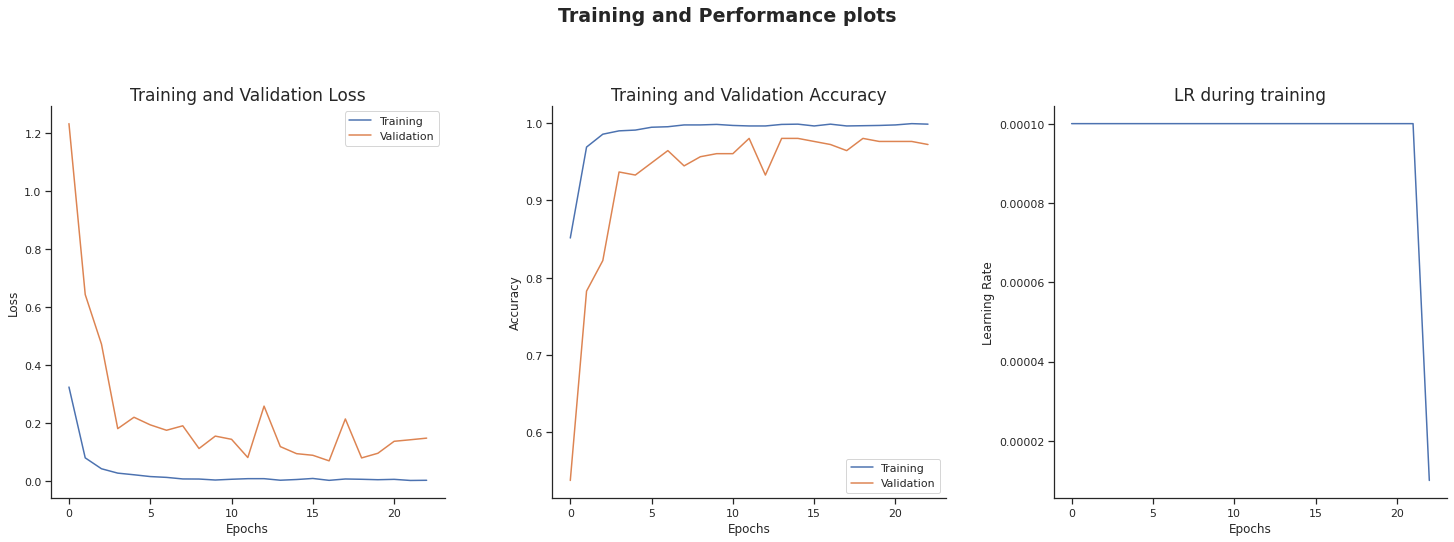

In [40]:
fig, axarr = plt.subplots(1,3, figsize=(21, 8), sharex=True)

sns.set(style="ticks", font_scale = 1)
sns.despine(top=True, right=True, left=False, bottom=False)

ax = sns.lineplot(x = historyDF.index, y = hist.history[metricsEval[0]], ax=axarr[0], label="Training");
ax = sns.lineplot(x = historyDF.index, y = hist.history[metricsEval[5]], ax=axarr[0], label="Validation");
ax.set_ylabel('Loss')

ax = sns.lineplot(x = historyDF.index, y = hist.history[metricsEval[1]], ax=axarr[1], label="Training");
ax = sns.lineplot(x = historyDF.index, y = hist.history[metricsEval[6]], ax=axarr[1], label="Validation");
ax.set_ylabel('Accuracy')

ax = sns.lineplot(x = historyDF.index, y = hist.history[metricsEval[10]], ax=axarr[2]);
ax.set_ylabel('Learning Rate')

axarr[0].set_title('Training and Validation Loss', fontsize=17)
axarr[1].set_title('Training and Validation Accuracy', fontsize=17)
axarr[2].set_title('LR during training', fontsize=17)

for ax in axarr:
    ax.set_xlabel('Epochs')

plt.suptitle('Training and Performance plots', fontsize=19, weight='bold');
fig.tight_layout(pad=3.0)
plt.show()

In [41]:
loss , acc , recall , precision , auc = model.evaluate(train_dataset)
print("\n---------------- Evaluation on Train DataSet ----------------\n")
print(f'Loss on Train set: {loss:.4f}')
print(f'Accuracy on Train set: {acc*100:.2f}%')
print(f'Recall on Train set: {recall:.2f}')
print(f'Precision on Train set: {precision:.2f}')
print(f'AUC on Train set: {auc:.2f}')

47/47 [==============================] - 58s 1s/step - loss: 0.0213 - accuracy: 0.9937 - recall: 0.9920 - precision: 0.9953 - auc: 0.9988

---------------- Evaluation on Train DataSet ----------------

Loss on Train set: 0.0213
Accuracy on Train set: 99.37%
Recall on Train set: 0.99
Precision on Train set: 1.00
AUC on Train set: 1.00


In [42]:
loss , acc , recall , precision , auc = model.evaluate(test_dataset)
print("\n---------------- Evaluation on Test DataSet ----------------\n")
print(f'Loss on Test set: {loss:.4f}')
print(f'Accuracy on Test set: {acc*100:.2f}%')
print(f'Recall on Test set: {recall:.2f}')
print(f'Precision on Test set: {precision:.2f}')
print(f'AUC on Test set: {auc:.2f}')

4/4 [==============================] - 5s 1s/step - loss: 0.0726 - accuracy: 0.9802 - recall: 0.9806 - precision: 0.9870 - auc: 0.9940      

---------------- Evaluation on Test DataSet ----------------

Loss on Test set: 0.0726
Accuracy on Test set: 98.02%
Recall on Test set: 0.98
Precision on Test set: 0.99
AUC on Test set: 0.99
